# Local-Tangent DDM + Geometric Harmonics

We compare a plain time-domain linear interpolation against the **local geometric harmonics (LGH)** pipeline:

1. Build the separable+coupling operator $P=(1-\eta)P_{	ext{geo}}+\eta P_{	ext{cpl}}$ to encode diffusion (geometry) and deterministic forward transport.
2. Embed frames with diffusion maps (symmetric part of $P$), fit monotone transport splines in the latent chart, and evaluate them at the held-out time.
3. Apply **local** GH lifting (k-NN Nyström + ridge) to reconstruct the held-out frames and compare against the linear baseline.

In [1]:
import numpy as np
from pathlib import Path
import sys

sys.path.append(str(Path.cwd().parent))

PROJECT_ROOT = Path.cwd().resolve()
DATA_PATH = None
for candidate in (PROJECT_ROOT / 'data/mm_data.npz', PROJECT_ROOT.parent / 'data/mm_data.npz'):
    if candidate.exists():
        DATA_PATH = candidate
        break
if DATA_PATH is None:
    raise FileNotFoundError('Could not locate data/mm_data.npz relative to this notebook.')

print(f"Using dataset: {DATA_PATH}")

def load_full_dataset() -> tuple[np.ndarray, np.ndarray]:
    """Return times and reconstructed frames with shape (n_times, n_samples, H, W)."""
    data = np.load(DATA_PATH)
    keys = sorted(
        [k for k in data.files if k.startswith('marginal_') and not k.startswith('raw_')],
        key=lambda k: float(k.split('_')[-1]),
    )
    times = np.array([float(k.split('_')[-1]) for k in keys], dtype=np.float64)

    coeffs = [data[k] for k in keys]
    components = data['pca_components']
    mean = data['pca_mean']
    variance = data['pca_explained_variance']
    whitened = bool(data['is_whitened'])
    side = int(np.sqrt(int(data['data_dim'])))
    sqrt_var = np.sqrt(np.maximum(variance, 1e-12))

    frames = []
    for matrix in coeffs:
        coeff_matrix = matrix
        if whitened:
            coeff_matrix = coeff_matrix * sqrt_var[None, :]
        fields = coeff_matrix @ components + mean
        frames.append(fields.reshape(-1, side, side))
    frames = np.stack(frames)  # (n_times, n_samples, H, W)
    return times, frames

all_times, all_frames = load_full_dataset()
n_times, n_samples, height, width = all_frames.shape
print(f"Recovered dataset shape: {all_frames.shape} (time, samples, H, W)")
print(f"Time grid: {all_times}")

Using dataset: /data1/jy384/research/MMSFM/data/mm_data.npz
Recovered dataset shape: (5, 1000, 32, 32) (time, samples, H, W)
Time grid: [0.   0.25 0.5  0.75 1.  ]


In [23]:
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import kneighbors_graph

holdout_idx = len(all_times) // 2
train_times = np.delete(all_times, holdout_idx)
holdout_time = float(all_times[holdout_idx])
holdout_frames = all_frames[holdout_idx]

train_frames = np.delete(all_frames, holdout_idx, axis=0)
T_train = train_frames.shape[0]
grid_shape = train_frames.shape[-2:]

# Reshape to sample-major ordering for diffusion maps
train_nodes = train_frames.transpose(1, 0, 2, 3).reshape(-1, *grid_shape)
tabular_train_frames = train_nodes.reshape(train_nodes.shape[0], -1)
num_frames = train_nodes.shape[0]
flat_frames = train_nodes.reshape(num_frames, -1)

frame_times = np.tile(train_times, n_samples)
sample_ids = np.repeat(np.arange(n_samples), T_train)

# Build a symmetric k-NN distance graph to sparsify pairwise distances
K_neighbors = min(256, max(1, num_frames - 1))
knn_graph = kneighbors_graph(
    flat_frames,
    K_neighbors,
    mode='distance',
    metric='euclidean',
    include_self=False,
)
knn_graph = knn_graph.maximum(knn_graph.T)  # ensure symmetry
knn_graph.data **= 2  # store squared distances

# Expand the sparse graph into a dense matrix with inf for missing edges
spatial_distances2 = np.full((num_frames, num_frames), np.inf, dtype=np.float64)
np.fill_diagonal(spatial_distances2, 0.0)
coo_graph = knn_graph.tocoo()
spatial_distances2[coo_graph.row, coo_graph.col] = coo_graph.data

finite_edges = np.isfinite(spatial_distances2) & (spatial_distances2 > 0)
if not np.any(finite_edges):
    raise RuntimeError('k-NN graph did not produce any finite pairwise distances.')
neighbor_median = float(np.median(spatial_distances2[finite_edges]))
print(f"Median squared neighbor distance: {neighbor_median:.3e}")

print(f"Held-out time: t = {holdout_time:.2f}; training slices: {train_times}")
print(f"Total training frames: {num_frames} ({n_samples} samples × {T_train} times)")

# Simple linear baseline evaluated sample-wise
lower_mask = train_times < holdout_time
upper_mask = train_times > holdout_time
linear_rmse = None
linear_pred = None
linear_rmse_per_sample = None
if np.any(lower_mask) and np.any(upper_mask):
    t_lo = train_times[lower_mask][-1]
    t_hi = train_times[upper_mask][0]
    time_to_idx = {t: idx for idx, t in enumerate(train_times)}
    frame_lo = train_frames[time_to_idx[t_lo]]
    frame_hi = train_frames[time_to_idx[t_hi]]
    w = (holdout_time - t_lo) / (t_hi - t_lo)
    linear_pred = (1 - w) * frame_lo + w * frame_hi
    linear_rmse_per_sample = np.sqrt(np.mean((linear_pred - holdout_frames) ** 2, axis=(1, 2)))
    linear_rmse = float(linear_rmse_per_sample.mean())
    print(f"Linear baseline mean RMSE: {linear_rmse:.4f}")
else:
    print('Linear baseline unavailable (held-out slice at boundary).')

Median squared neighbor distance: 6.588e+02
Held-out time: t = 0.50; training slices: [0.   0.25 0.75 1.  ]
Total training frames: 4000 (1000 samples × 4 times)
Linear baseline mean RMSE: 0.1020


In [33]:
from scipy import sparse
from diffmap.diffusion_maps import (
    construct_time_coupled_operator,
    diffusion_embedding,
    select_non_harmonic_coordinates,
    fit_coordinate_splines,
    evaluate_coordinate_splines,
    fit_geometric_harmonics,
    geometric_harmonics_lift,
    geometric_harmonics_lift_local,
)

eta_blend = 0.4
alpha = 0.0
spatial_epsilon = 0.25 * neighbor_median  # operate on squared distances

temporal_delta2 = (frame_times[:, None] - frame_times[None, :]) ** 2
temporal_mask = temporal_delta2 > 0
temporal_epsilon = (
    float(np.median(temporal_delta2[temporal_mask]))
    if np.any(temporal_mask)
    else 1.0
)

geo_operator = construct_time_coupled_operator(
    flat_frames,
    frame_times,
    sample_ids,
    spatial_distances2=spatial_distances2,
    spatial_epsilon=spatial_epsilon,
    temporal_epsilon=temporal_epsilon,
    alpha=alpha,
    eta=0.0,
)
blended_operator = geo_operator.with_eta(eta_blend)

print(f"Spatial bandwidth ε_x = {geo_operator.spatial_epsilon:.3f}")
print(f"Temporal bandwidth ε_t = {geo_operator.temporal_epsilon:.3f}")

Spatial bandwidth ε_x = 164.695
Temporal bandwidth ε_t = 0.406


In [43]:
def run_ddm_pipeline(
    operator,
    label,
    *,
    use_monotone: bool,
    use_local: bool,
    k_neighbors: int = 64,
    delta: float = 1e-4,
    ridge: float = 1e-8,
    window_mode: str | None = None,
):
    print(f"=== {label} ===")
    W = sparse.csr_matrix(operator.symmetric)
    max_coords = min(32, W.shape[0] - 1)
    evals, dm_coords = diffusion_embedding(W, r=max_coords, alpha=alpha)
    non_harm, mask, residuals = select_non_harmonic_coordinates(
        evals,
        dm_coords,
        residual_threshold=0.1,
        min_coordinates=2,
    )
    print(f"Top eigenvalues: {evals[:5]}")
    print(f"Retained coords: {mask.sum()} / {mask.size}")

    spline_type = 'pchip' if use_monotone else 'cubic'
    if window_mode is None:
        window_mode = 'triplet' if use_monotone else 'global'
    print(f"Coordinate spline mode: {window_mode} ({spline_type})")

    sample_splines: list = []
    for sample_idx in range(n_samples):
        start = sample_idx * T_train
        end = start + T_train
        coords_sample = non_harm[start:end]
        splines = fit_coordinate_splines(
            coords_sample,
            train_times,
            spline_type=spline_type,
            window_mode=window_mode,
        )
        sample_splines.append(splines)

    g_star = np.vstack([
        evaluate_coordinate_splines(splines, holdout_time).ravel()
        for splines in sample_splines
    ])
    gh_model = fit_geometric_harmonics(
        non_harm,
        tabular_train_frames,
        delta=delta,
        ridge=ridge,
        grid_shape=grid_shape,
    )

    if use_local:
        local_delta = delta
        prediction = geometric_harmonics_lift_local(
            g_star,
            gh_model,
            k_neighbors=k_neighbors,
            delta=local_delta,
            ridge=ridge,
            max_local_modes=8,
        )
    else:
        prediction = geometric_harmonics_lift(g_star, gh_model)
    
    prediction = prediction.reshape(-1, *grid_shape)

    rmse_per_sample = np.sqrt(np.mean((prediction - holdout_frames) ** 2, axis=(1, 2)))
    rmse_mean = float(rmse_per_sample.mean())
    print(f"DDM+GH mean RMSE: {rmse_mean:.4f}")
    if linear_rmse is not None:
        print(f"Linear baseline RMSE: {linear_rmse:.4f}")

    return {
        'label': label,
        'evals': evals,
        'dm_coords': dm_coords,
        'mask': mask,
        'residuals': residuals,
        'rmse_mean': rmse_mean,
        'rmse_per_sample': rmse_per_sample,
        'prediction': prediction,
        'use_monotone': use_monotone,
        'use_local': use_local,
        'window_mode': window_mode,
        'sample_splines': sample_splines,
        'gh_model': gh_model,
        'delta': delta,
        'ridge': ridge,
        'k_neighbors': k_neighbors,
    }

In [44]:
geo_result = run_ddm_pipeline(
    geo_operator,
    'Reversible separable kernel (η=0.0)',
    use_monotone=True,
    use_local=False,
    delta=1e-3
)

=== Reversible separable kernel (η=0.0) ===
Top eigenvalues: [0.92063659 0.82105947 0.79849153 0.79276658 0.79212746]
Retained coords: 24 / 32
Coordinate spline mode: triplet (pchip)
DDM+GH mean RMSE: 0.5761
Linear baseline RMSE: 0.1020


In [36]:
lgh_result = run_ddm_pipeline(
    geo_operator,
    f'Blended kernel (η={eta_blend}) with local GH',
    use_monotone=True,
    use_local=True,
    k_neighbors=32,
    delta=1e-3,
    ridge=1e-8,
)

=== Blended kernel (η=0.4) with local GH ===
Top eigenvalues: [0.92063659 0.82105947 0.79849153 0.79276658 0.79212746]
Retained coords: 24 / 32
Coordinate spline mode: triplet (pchip)
DDM+GH mean RMSE: 0.5749
Linear baseline RMSE: 0.1020


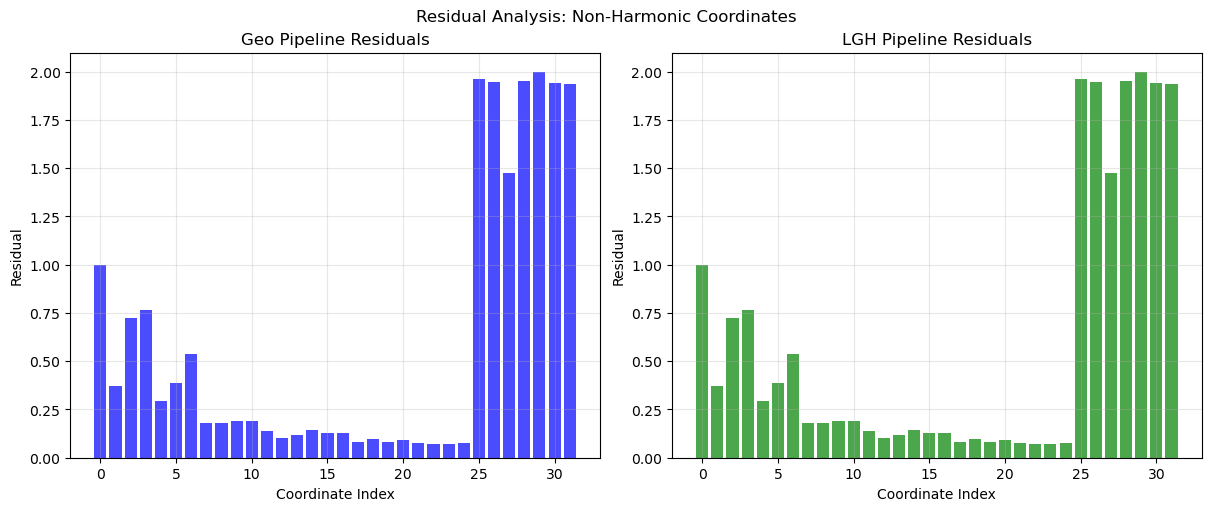

In [37]:
import matplotlib.pyplot as plt

geo_residuals = geo_result['residuals']
lgh_residuals = lgh_result['residuals']

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

axes[0].bar(range(len(geo_residuals)), geo_residuals, color='blue', alpha=0.7)
axes[0].set_xlabel('Coordinate Index')
axes[0].set_ylabel('Residual')
axes[0].set_title('Geo Pipeline Residuals')
axes[0].grid(True, alpha=0.3)

axes[1].bar(range(len(lgh_residuals)), lgh_residuals, color='green', alpha=0.7)
axes[1].set_xlabel('Coordinate Index')
axes[1].set_ylabel('Residual')
axes[1].set_title('LGH Pipeline Residuals')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Residual Analysis: Non-Harmonic Coordinates')
plt.show()

Summary:
  Linear baseline RMSE : 0.1020
  Reversible kernel RMSE: 0.5761
  LGH blended RMSE     : 0.5749


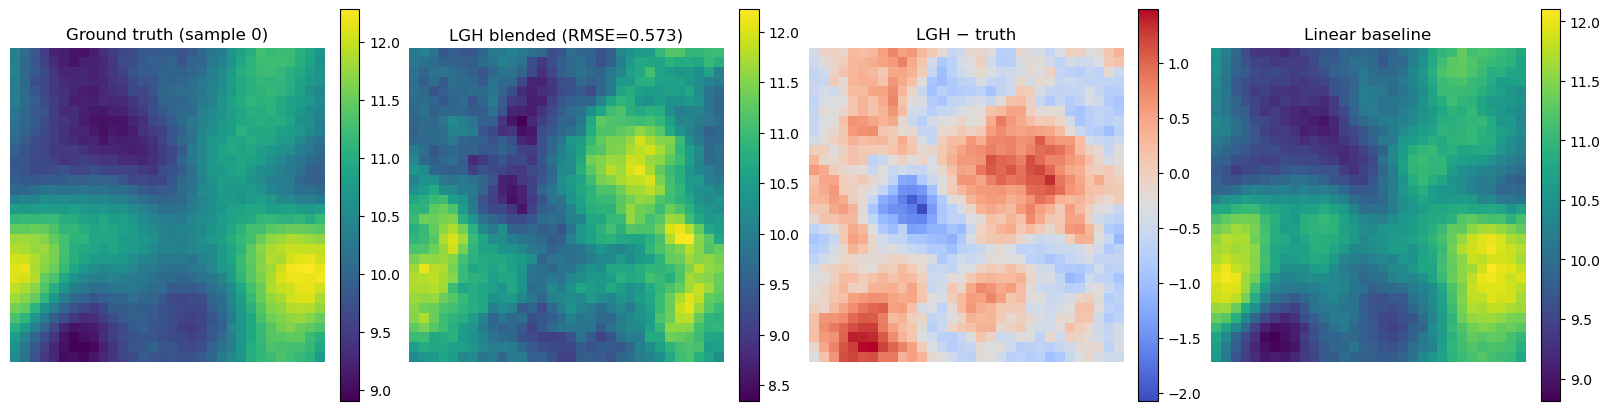

In [38]:
if 'lgh_result' not in globals() or lgh_result is None:
    raise RuntimeError('Run the LGH experiment before plotting.')

print('Summary:')
if linear_rmse is not None:
    print(f"  Linear baseline RMSE : {linear_rmse:.4f}")
print(f"  Reversible kernel RMSE: {geo_result['rmse_mean']:.4f}")
print(f"  LGH blended RMSE     : {lgh_result['rmse_mean']:.4f}")

try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    print('matplotlib is not installed; skipping plots. Install matplotlib to view figures.')
else:
    sample_to_plot = 0
    cols = 4 if linear_pred is not None else 3
    fig, axes = plt.subplots(1, cols, figsize=(4 * cols, 4), constrained_layout=True)
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    im0 = axes[0].imshow(holdout_frames[sample_to_plot], cmap='viridis')
    axes[0].set_title(f'Ground truth (sample {sample_to_plot})')
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(lgh_result['prediction'][sample_to_plot], cmap='viridis')
    axes[1].set_title(
        f"LGH blended (RMSE={lgh_result['rmse_per_sample'][sample_to_plot]:.3f})"
    )
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(
        lgh_result['prediction'][sample_to_plot] - holdout_frames[sample_to_plot],
        cmap='coolwarm',
    )
    axes[2].set_title('LGH − truth')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2])

    if linear_pred is not None and cols == 4:
        im3 = axes[3].imshow(linear_pred[sample_to_plot], cmap='viridis')
        axes[3].set_title('Linear baseline')
        axes[3].axis('off')
        plt.colorbar(im3, ax=axes[3])

In [52]:
geo_result['gh_model'].g_train[0]

array([ 1.35929475e-02,  6.22983664e-03,  6.94858208e-03, -2.52625661e-03,
        1.22033624e-02, -9.24938886e-04,  2.03485208e-03, -1.23627278e-02,
        2.10034283e-02, -1.96671921e-03,  8.29345521e-04,  9.28101687e-04,
        9.10961515e-03,  1.46818051e-02,  1.51711864e-02,  6.92102642e-03,
       -7.20407430e-03, -2.77658376e-03, -3.62807810e-05, -1.78528949e-04,
       -2.91062546e-04,  1.40825227e-03,  2.90934757e-06,  2.51016306e-04])

In [53]:
g_latent_first

array([[-2.22902994e-03, -1.36330775e-02, -1.39583725e-02,
        -3.62559100e-02, -9.08197060e-03, -9.94348683e-03,
         6.12451661e-03, -2.11717057e-04,  5.80770848e-03,
        -1.36215393e-02, -7.14705712e-03, -1.81436250e-02,
        -4.04834074e-03, -1.65662679e-02, -3.51525867e-03,
        -4.63023591e-03, -6.53229227e-03,  3.03527398e-03,
         2.41820253e-04,  2.83044289e-04,  3.50845875e-05,
         1.85105536e-04,  2.35943555e-05,  2.26971411e-06]])

Evaluating reconstruction at t = 0.00 (training slice)
Using sample index 0
Geo pipeline RMSE at first time step: 1.7747


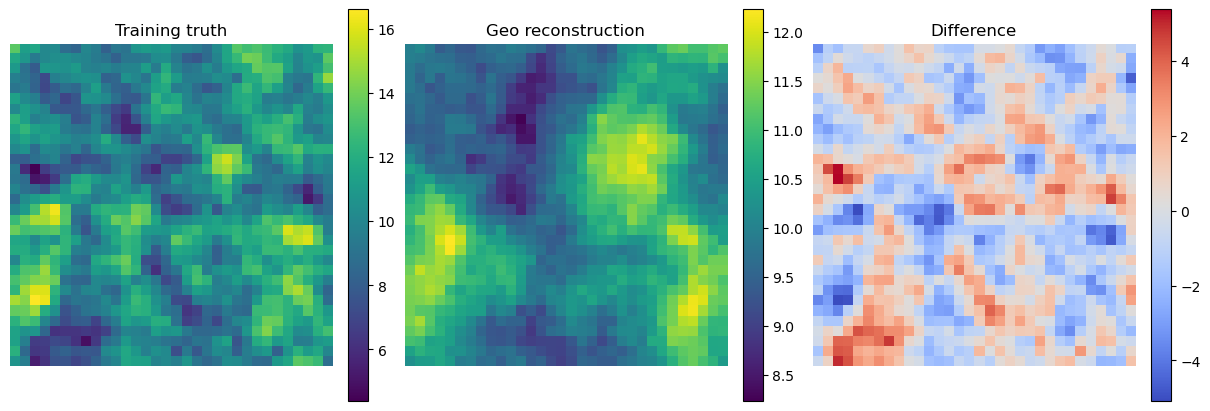

In [56]:
first_train_time = float(train_times[0])
if np.isclose(first_train_time, holdout_time):
    if len(train_times) < 2:
        raise RuntimeError('Training grid collapsed onto holdout time; cannot test first step reconstruction.')
    first_train_time = float(train_times[1])

sample_test_idx = 0
geo_splines_test = geo_result['sample_splines'][sample_test_idx]

g_latent_first = evaluate_coordinate_splines(geo_splines_test, first_train_time).ravel()[None, :]

first_time_index = int(np.argmin(np.abs(train_times - first_train_time)))
g_train_index = sample_test_idx * T_train + first_time_index
g_latent_train = geo_result['gh_model'].g_train[g_train_index:g_train_index+1]

assert np.allclose(g_latent_first, g_latent_train, atol=1e-3), "Latent coordinates do not match training data at first time step"

geo_recon_first = geometric_harmonics_lift(g_latent_first, geo_result['gh_model'])[0].reshape(*grid_shape)

truth_first = train_frames[first_time_index, sample_test_idx]
rmse_first_geo = float(np.sqrt(np.mean((geo_recon_first - truth_first) ** 2)))

print(f"Evaluating reconstruction at t = {first_train_time:.2f} (training slice)")
print(f"Using sample index {sample_test_idx}")
print(f"Geo pipeline RMSE at first time step: {rmse_first_geo:.4f}")

try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    print('matplotlib is not installed; skipping comparison plot.')
else:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

    im0 = axes[0].imshow(truth_first, cmap='viridis')
    axes[0].set_title('Training truth')
    axes[0].axis('off')
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(geo_recon_first, cmap='viridis')
    axes[1].set_title('Geo reconstruction')
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1])

    diff = geo_recon_first - truth_first
    im2 = axes[2].imshow(diff, cmap='coolwarm')
    axes[2].set_title('Difference')
    axes[2].axis('off')
    fig.colorbar(im2, ax=axes[2])


Evaluating reconstruction at t = 0.00 (training slice)
Using sample index 1
LGH pipeline RMSE at first time step: 1.5760


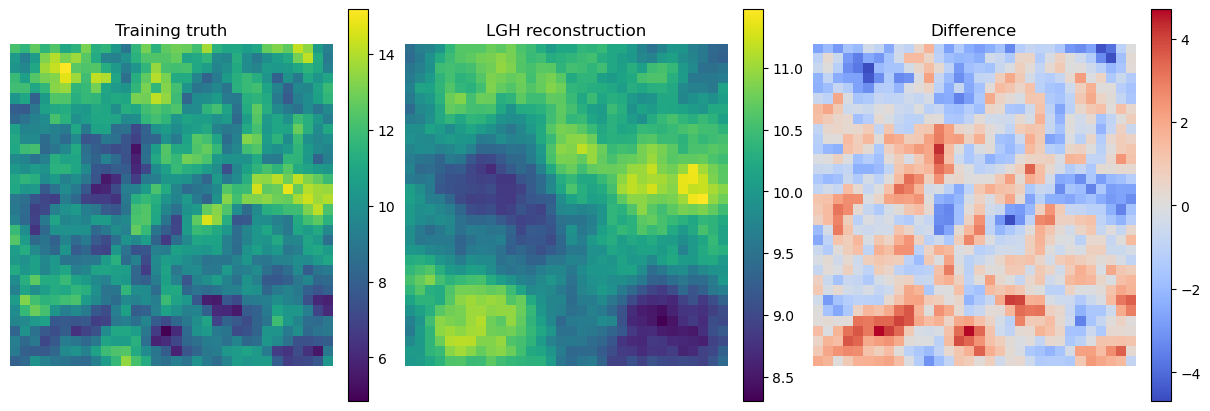

In [ ]:
first_train_time = float(train_times[0])
if np.isclose(first_train_time, holdout_time):
    if len(train_times) < 2:
        raise RuntimeError('Training grid collapsed onto holdout time; cannot test first step reconstruction.')
    first_train_time = float(train_times[1])

sample_test_idx = 0
lgh_splines_test = lgh_result['sample_splines'][sample_test_idx]

g_latent_first = evaluate_coordinate_splines(lgh_splines_test, first_train_time).ravel()[None, :]

first_time_index = int(np.argmin(np.abs(train_times - first_train_time)))
g_train_index = sample_test_idx * T_train + first_time_index
g_latent_train = lgh_result['dm_coords'][g_train_index:g_train_index+1]

assert np.allclose(g_latent_first, g_latent_train, atol=1e-2), "Latent coordinates do not match training data at first time step"

lgh_recon_first = geometric_harmonics_lift(g_latent_first, lgh_result['gh_model'])[0].reshape(*grid_shape)

truth_first = train_frames[first_time_index, sample_test_idx]
rmse_first_lgh = float(np.sqrt(np.mean((lgh_recon_first - truth_first) ** 2)))

print(f"Evaluating reconstruction at t = {first_train_time:.2f} (training slice)")
print(f"Using sample index {sample_test_idx}")
print(f"LGH pipeline RMSE at first time step: {rmse_first_lgh:.4f}")

try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    print('matplotlib is not installed; skipping comparison plot.')
else:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

    im0 = axes[0].imshow(truth_first, cmap='viridis')
    axes[0].set_title('Training truth')
    axes[0].axis('off')
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(lgh_recon_first, cmap='viridis')
    axes[1].set_title('LGH reconstruction')
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1])

    diff = lgh_recon_first - truth_first
    im2 = axes[2].imshow(diff, cmap='coolwarm')
    axes[2].set_title('Difference')
    axes[2].axis('off')
    fig.colorbar(im2, ax=axes[2])


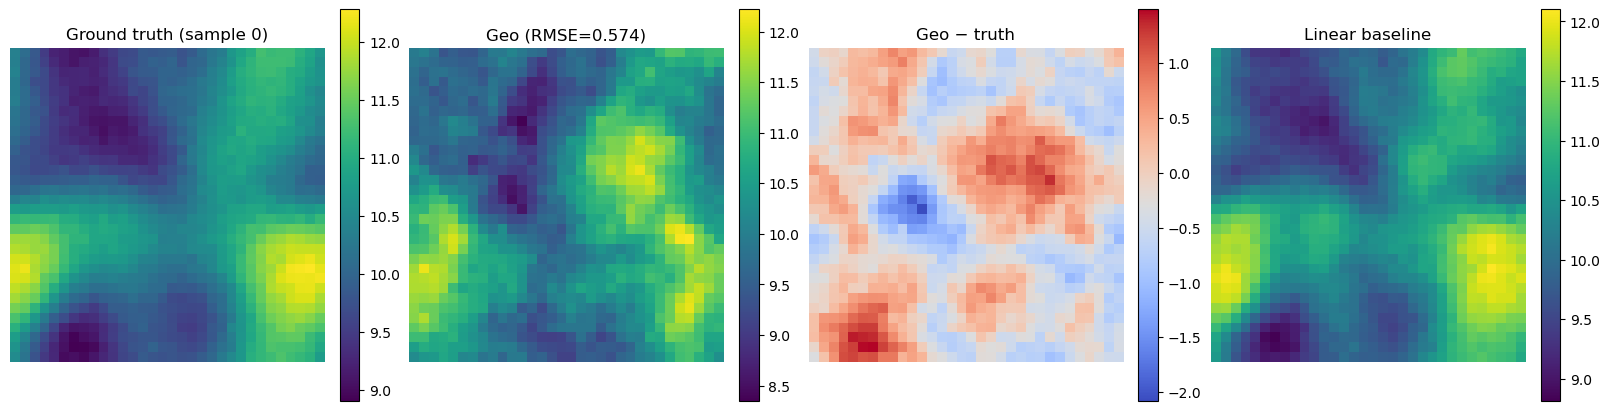

In [57]:
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    print('matplotlib is not installed; skipping plots. Install matplotlib to view figures.')
else:
    sample_to_plot = 0
    cols = 4 if linear_pred is not None else 3
    fig, axes = plt.subplots(1, cols, figsize=(4 * cols, 4), constrained_layout=True)
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    im0 = axes[0].imshow(holdout_frames[sample_to_plot], cmap='viridis')
    axes[0].set_title(f'Ground truth (sample {sample_to_plot})')
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(geo_result['prediction'][sample_to_plot], cmap='viridis')
    axes[1].set_title(
        f"Geo (RMSE={geo_result['rmse_per_sample'][sample_to_plot]:.3f})"
    )
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(
        geo_result['prediction'][sample_to_plot] - holdout_frames[sample_to_plot],
        cmap='coolwarm',
    )
    axes[2].set_title('Geo − truth')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2])

    if linear_pred is not None and cols == 4:
        im3 = axes[3].imshow(linear_pred[sample_to_plot], cmap='viridis')
        axes[3].set_title('Linear baseline')
        axes[3].axis('off')
        plt.colorbar(im3, ax=axes[3])